In [1]:
%reload_ext autoreload
%autoreload 2

%matplotlib widget

from tqdm import tqdm
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import ttest_rel
from vrAnalysis.helpers import errorPlot
from photometry.loaders import get_files, process_data_parallel, process_single_file
from photometry.process import analyze_data
from syd import make_viewer

In [31]:
mouse_name = "ATL068"
dirs, findex, data = get_files(mouse_name)
print(f"Found {len(data)} files")
print(dirs)

Could not parse file index from D:\localData\ATL068\2025-03-07/ATL068_2025-03-07.doric
Found 18 files
['2025-02-28', '2025-03-05', '2025-03-06', '2025-03-10', '2025-03-12', '2025-03-14', '2025-03-19', '2025-03-20', '2025-03-21', '2025-03-24', '2025-03-27', '2025-03-28', '2025-04-02', '2025-04-03', '2025-04-04', '2025-04-07', '2025-04-09', '2025-04-10']


In [32]:
# Get the results from all sessions of the data files
preperiod = 0.2
postperiod = 1.2
results, opto_responses = process_data_parallel(data, preperiod=preperiod, postperiod=postperiod, parallel=False)

Processing files:  78%|███████▊  | 14/18 [00:08<00:02,  1.65it/s]


ValueError: Too many consecutive bad periods in channel 2

In [ ]:
import numpy as np

def plot(state):
    idx_session = state["idx_session"]
    
    res = results[idx_session]

    cmap = plt.get_cmap("cividis")
    colors = np.array([cmap(i/len(results)) for i in range(len(results))])

    fig = plt.figure(figsize=(8, 3), layout="constrained")
    gs = fig.add_gridspec(1, 4, width_ratios=[1, 1, 0.2, 1.0], wspace=0.1)

    # Plot all sessions
    ax = fig.add_subplot(gs[0])
    for iresponse, response in enumerate(opto_responses):
        ax.plot(res["time_opto_response"], response, color=colors[iresponse] if iresponse != idx_session else "k", zorder=1 if iresponse != idx_session else 1000)
    ax.set_xlim(-preperiod, postperiod/2)
    ax.axhline(0, color="black", linewidth=0.5, linestyle="--", zorder=-100)
    ax.set_xlabel("Time (s)")
    ax.set_ylabel(r"$\Delta$ Fluorescence (a.u.)")
    ax.set_title("Session Averages")

    # Plot the current session's data in particular
    ax = fig.add_subplot(gs[1])
    errorPlot(res["time_opto"], res["in1_opto"], se=True, axis=0, ax=ax, alpha=0.2, color="black", label="iso", handle_nans=True)
    errorPlot(res["time_opto"], res["in2_opto"], se=True, axis=0, ax=ax, alpha=0.2, color="green", label="fluor", handle_nans=True)
    ax.axvline(0, color="black", linewidth=0.5, linestyle="--", zorder=-100)
    ax.legend(loc="upper right")
    ax.set_xlabel("Time (s)")
    ax.set_ylabel(r"$\Delta$ Fluorescence (a.u.)")
    ax.set_title("Session Average")
    ax.set_xlim(-preperiod, postperiod)

    ax_cbar = fig.add_subplot(gs[2])
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(0, len(results)-1))
    cbar = plt.colorbar(sm, cax=ax_cbar, label='Session #')
    cbar.set_ticks([0, len(results)-1])  # Only show first and last session numbers
    cbar.set_ticklabels(['1', str(len(results))])  # Label them as 1 and max

    # Plot all the data from the selected session
    ax = fig.add_subplot(gs[3])
    relative_data = res["in2_opto"] - res["in1_opto"]
    relative_data = relative_data - np.median(relative_data)
    relative_data = relative_data / np.std(relative_data)
    ax.imshow(relative_data, aspect="auto", cmap="bwr", extent=[-preperiod, postperiod, 0, len(relative_data)], vmin=-state["vmax"], vmax=state["vmax"])
    ax.axvline(0, color="black", linewidth=0.5, linestyle="--")
    ax.set_xlim(-preperiod, postperiod)
    ax.set_ylim(0, len(relative_data))
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Trial #")
    ax.set_title("Session Trials")
    
    fig.suptitle(f"{mouse_name}")
    return fig


viewer = make_viewer(plot)
viewer.add_integer("idx_session", value=12, min=0, max=len(results)-1)
viewer.add_float("vmax", value=4.0, min=0.1, max=10)
viewer = viewer.deploy(env="notebook")

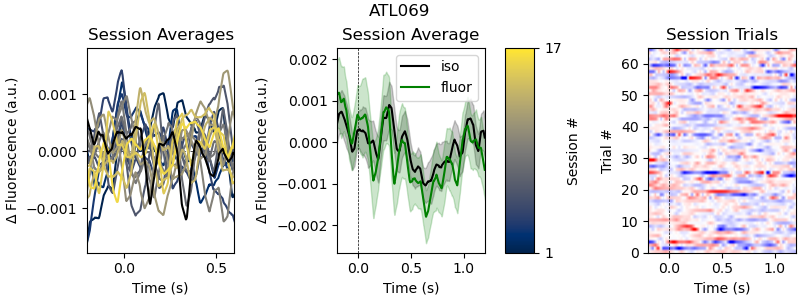

In [ ]:
from vrAnalysis2.helpers import save_figure
from vrAnalysis2.files import repo_path
figure_path = repo_path() / "figures" / "photometry" / f"{mouse_name}.png"
fig = viewer.plot(viewer.state)
save_figure(fig, figure_path)

In [23]:
data[0].keys()

dict_keys(['in_time', 'in_data', 'out_time', 'out1', 'out2', 'out3', 'index'])

In [74]:
c_results = analyze_data(data[1], preperiod=0.2, postperiod=3.0, prctile_filter_size=None, include_debug_outputs=True)

In [34]:
c_results.keys()

dict_keys(['in1_opto', 'in2_opto', 'out3_opto', 'time_opto', 'opto_start_time', 'data_in1', 'data_in2', 'data_opto', 'time_data', 'cycle_timestamps', 'in1', 'in2', 'start1', 'stop1', 'start2', 'stop2', 'init_start3', 'start3'])

In [20]:
c_results["in1"].shape, c_results["in2"].shape, c_results["cycle_timestamps"].shape

((11720,), (11720,), (11720,))

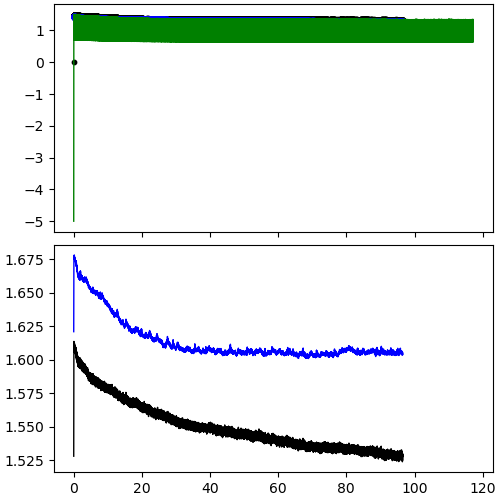

In [75]:
plt.close('all')
fig, ax = plt.subplots(2, 1, figsize=(5, 5), layout="constrained", sharex=True)
ax[0].plot(data[0]["in_time"], data[0]["in_data"], c='g', linewidth=1.0)
ax[0].scatter(data[0]["in_time"][c_results["start1"]], data[0]["in_data"][c_results["start1"]], c='k', s=10)
ax[0].scatter(data[0]["in_time"][c_results["start2"]], data[0]["in_data"][c_results["start2"]], c='b', s=10)
ax[1].plot(c_results["time_data"], c_results["data_in1"], c='k', linewidth=1.0)
ax[1].plot(c_results["time_data"], c_results["data_in2"], c='b', linewidth=1.0)
plt.show()

In [77]:
np.where(c_results["time_opto"] == 0.0)

(array([200], dtype=int64),)

In [82]:
c_results["time_opto"].shape, c_results["in1_opto"].shape

((3200,), (30, 3200))

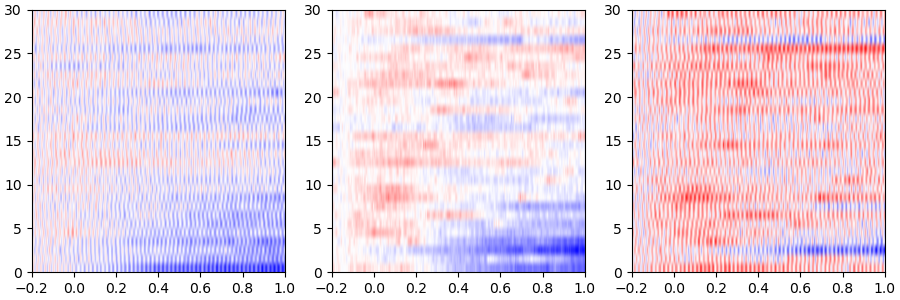

In [83]:
fig, ax = plt.subplots(1, 3, figsize=(9, 3), layout="constrained")
in1 = c_results["in1_opto"] - np.mean(c_results["in1_opto"][:, 100:190], axis=1, keepdims=True)
in2 = c_results["in2_opto"] - np.mean(c_results["in2_opto"][:, 100:190], axis=1, keepdims=True)
dff = in2 - in1

max_value = max([np.max(np.abs(in1)), np.max(np.abs(in2)), np.max(np.abs(dff))])
ax[0].imshow(in1, aspect="auto", cmap="bwr", extent=[-preperiod, postperiod, 0, len(in1)], origin="lower", vmin=-max_value, vmax=max_value)
ax[1].imshow(in2, aspect="auto", cmap="bwr", extent=[-preperiod, postperiod, 0, len(c_results["in2_opto"])], origin="lower", vmin=-max_value, vmax=max_value)
ax[2].imshow(in2-in1, aspect="auto", cmap="bwr", extent=[-preperiod, postperiod, 0, len(c_results["in1_opto"])], origin="lower")

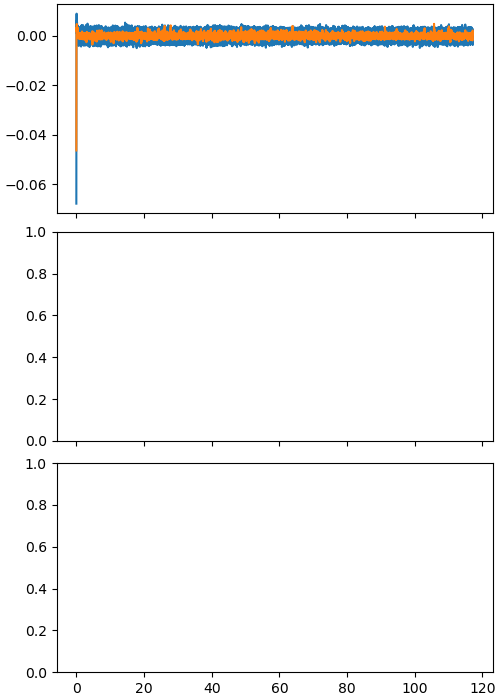

In [8]:
fig, ax = plt.subplots(3, 1, figsize=(5, 7), layout="constrained", sharex=True)
ax[0].plot(results[0]["time_data"], results[0]["data_in1"])
ax[0].plot(results[0]["time_data"], results[0]["data_in2"])
# ax[1].plot(results[0]["time_data"], results[0]["out1"], c="k", label="out1")
# ax[1].plot(results[0]["time_data"], results[0]["out2"], c="r", label="out2")
# ax[2].plot(results[0]["time_data"], results[0]["out3"], c="k")
# ax[1].legend()
plt.show()